In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt

# Demo 1 - Bayesian Lasso

In [16]:
n = 50
k = 100

np.random.seed(1234)
X = np.random.normal(size=(n, k))

beta = np.zeros(shape=k)
beta[[10,30,50,70]] =  10
beta[[20,40,60,80]] = -10

y = X @ beta + np.random.normal(size=n)

## Naive Model

In [17]:
with pm.Model() as bayes_lasso:
  b = pm.Laplace("beta", 0, 1, shape=k)#lam*tau, shape=k)
  y_est = X @ b

  s = pm.HalfNormal('sigma', sd=1)

  likelihood = pm.Normal("y", mu=y_est, sigma=s, observed=y)

with bayes_lasso:
  trace = pm.sample(return_inferencedata=True, random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.878942077718847, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


In [18]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.067,0.861,-1.650,1.681,0.015,0.015,3234.0,1938.0,1.00
beta[1],0.215,0.729,-1.133,1.693,0.012,0.013,3632.0,2284.0,1.00
beta[2],-0.080,0.852,-1.789,1.501,0.014,0.015,3866.0,2652.0,1.00
beta[3],-0.290,0.814,-1.926,1.193,0.016,0.015,2870.0,1729.0,1.00
beta[4],0.079,0.809,-1.479,1.691,0.014,0.014,3577.0,2158.0,1.00
...,...,...,...,...,...,...,...,...,...
beta[96],0.106,0.726,-1.271,1.542,0.013,0.013,3471.0,2487.0,1.00
beta[97],-0.156,0.716,-1.591,1.160,0.013,0.013,3188.0,1798.0,1.00
beta[98],0.289,0.763,-1.076,1.827,0.014,0.015,3107.0,2408.0,1.00
beta[99],-0.278,0.768,-1.747,1.205,0.013,0.013,3575.0,2568.0,1.00


In [19]:
az.summary(trace).iloc[[0,10,20,30,40,50,60,70,80,100]]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.067,0.861,-1.650,1.681,0.015,0.015,3234.0,1938.0,1.00
beta[10],8.327,1.242,5.945,10.622,0.027,0.019,2075.0,2710.0,1.00
beta[20],-8.288,1.335,-10.697,-5.733,0.030,0.021,2003.0,1746.0,1.00
beta[30],8.610,1.023,6.678,10.447,0.023,0.017,2011.0,1702.0,1.00
beta[40],-8.765,1.507,-11.485,-5.929,0.030,0.022,2461.0,2531.0,1.00
beta[50],8.966,1.016,6.995,10.860,0.023,0.016,2035.0,1842.0,1.00
beta[60],-9.248,1.121,-11.381,-7.162,0.022,0.015,2708.0,2371.0,1.00
beta[70],8.521,1.210,6.220,10.788,0.026,0.018,2238.0,2575.0,1.00
beta[80],-9.923,0.899,-11.634,-8.253,0.018,0.013,2436.0,2003.0,1.00
sigma,0.980,0.478,0.275,1.859,0.046,0.032,102.0,211.0,1.05


In [ ]:
ax = az.plot_forest(trace)
plt.tight_layout()
plt.show()

#### Plot helper

In [21]:
def plot_slope(trace, prior="beta", chain=0):
  post = (trace.posterior[prior]
          .to_dataframe()
          .reset_index()
          .query("chain == 0")
  )

  sns.catplot(x="beta_dim_0", y="beta", data=post, kind="boxen", linewidth=0, color='blue', aspect=2, showfliers=False)
  plt.tight_layout()
  plt.show()

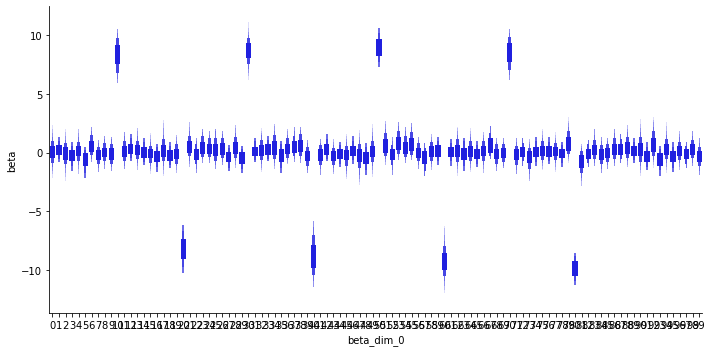

In [22]:
plot_slope(trace)

## Weakly Informative Prior


In [23]:
with pm.Model() as bayes_weak:
  b = pm.Normal("beta", 0, 10, shape=k)
  y_est = X @ b

  s = pm.HalfNormal('sigma', sd=2)

  likelihood = pm.Normal("y", mu=y_est, sigma=s, observed=y)

with bayes_weak:
  trace = pm.sample(return_inferencedata=True, random_seed=12345)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
The acceptance probability does not match the target. It is 0.9760397075294559, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7066410867916934, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9310317960474614, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_acce

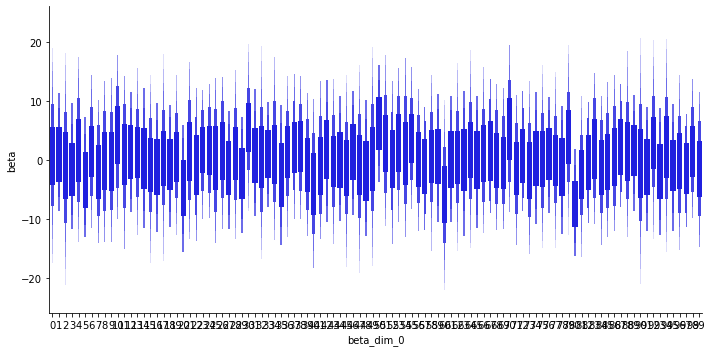

In [25]:
plot_slope(trace)